In [1]:
from pathlib import Path
import xarray as xr np
from xhistogram.xarray import histogram as xhist
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
#load 1st generation on shelf heatmaps as release zone
first_gen = xr.open_dataarray(Path("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/heatmaps_1st_gen.nc"))
first_gen100 = first_gen.isel(obs = slice(0,101)).sum('obs').mean('year').isel(lon_bin = slice(100,-1)) 
first_gen = first_gen.sum('obs').mean('year').isel(lon_bin = slice(100,-1))

In [3]:
year_list = np.arange(2007,2017).tolist()
data_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/")

u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[0]}*grid_U.nc"))
v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[0]}*grid_V.nc"))

ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,:,:]
ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,:,:]

ulat = ds_u.coords["nav_lat"].values[:,0]
ulon = ds_u.coords["nav_lon"].values[0,:]

y_ind = np.where((ulat > -8.5) & (ulat < 27.5))[0]
x_ind = np.where((ulon > -20) & (ulon <15))[0]
    
u_conc = ds_u[:,:,y_ind,x_ind].mean("depthu").mean('time_counter')
v_conc = ds_v[:,:,y_ind,x_ind].mean("depthv").mean('time_counter')


for year in year_list:
    u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year}*grid_U.nc"))
    v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year}*grid_V.nc"))
    
    ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,y_ind,x_ind].mean("depthu").mean('time_counter')
    ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,y_ind,x_ind].mean("depthv").mean('time_counter')
    
    u_conc = xr.concat((u_conc, ds_u), dim = 'year')
    v_conc = xr.concat((v_conc, ds_v), dim = 'year')
    
u_mean = u_conc.mean('year')
v_mean = v_conc.mean('year')
#for quiverplots
ulon = ulon[x_ind]
ulat = ulat[y_ind]

In [4]:
#load cell depths
t_file = "1_VIKING20X.L46-KFS003_1d_20110101_20111231_grid_T.nc"

lat_b = (-10,30)
lon_b = (-20,15)
t = xr.open_dataset(data_path / t_file)
t_lat = t.coords["nav_lat"].values[1:,0]
t_lon = t.coords["nav_lon"].values[0,:]

yt_ind = np.where((t_lat <= lat_b[1]) & (t_lat>= lat_b[0]))[0]  
xt_ind = np.where((t_lon <= lon_b[1]) & (t_lon >= lon_b[0]))[0]
mesh_t_lon, mesh_t_lat = np.meshgrid(t_lon[xt_ind],t_lat[yt_ind])

t_sel = t.vosaline[:,:,yt_ind,xt_ind].sel( # 5 oberste schichten
    time_counter = "2011-01-01") # 1 month december

depth_ind = t_sel.where(t_sel == 0).fillna(1).sum(dim = "deptht").astype('int')
depth_tgrid =  t_sel.deptht.isel(deptht = depth_ind).squeeze()
del t

In [6]:
#generate shelf bathymetry
dm = depth_tgrid
bath_canary = dm.where((dm['nav_lat'] >=27.65)&(dm['nav_lon'] <=-14.45))
bath_canary2 = dm.where((dm['nav_lat'] >=28)&(dm['nav_lon'] <=-13.45))
bath_fuerte = dm.where((dm['nav_lat'] >=28.4)&(dm['nav_lon'] <=-13.2))#cut eastern side of fuerteventure, Lanzarote
bath_smount = dm.where((dm['nav_lat'] >=29.5)&(dm['nav_lon'] <=-11.9))#cut  conception seamount
bath_saotome= dm.where((dm['nav_lat'] <=3.5)&(dm['nav_lon'] <=8.35)) #cut Sao Tome and Principe

dm = dm.where((bath_canary != dm)&(bath_canary2 != dm)&(bath_fuerte != dm)&(bath_smount != dm)&(bath_saotome != dm)& (depth_tgrid <= 500))

In [9]:
flon = first_gen.coords["lon_bin"].values 
flat = first_gen.coords["lat_bin"].values

dm_lon = dm.coords["nav_lon"].values[0,:]
dm_lat = dm.coords["nav_lat"].values[:,0]

ind_x = np.where((flon.min()<=dm_lon)&(flon.max()>=dm_lon))[0]
ind_y = np.where((flat.min()<=dm_lat)&(flat.max()>=dm_lat))[0]

on_shelf = xr.full_like(dm, np.nan)
on_shelf100 = xr.full_like(dm, np.nan)

In [10]:
#generate heatmaps of generation 1 on shelf 
on_shelf[ind_y, ind_x] = first_gen.isel(lon_bin = slice(0,-1), lat_bin = slice(0,-1)).values
on_shelf100[ind_y, ind_x] = first_gen100.isel(lon_bin = slice(0,-1), lat_bin = slice(0,-1)).values
#only where bincount >1 and on shelf
on_shelf = on_shelf.where((dm < 500)&(on_shelf>1))
on_shelf100 = on_shelf100.where((dm < 500)&(on_shelf100>1))

In [11]:
#plot_func
x_lines = np.arange(-50,30,10).tolist()
y_lines = np.arange(-10,35,5).tolist()
proj = ccrs.PlateCarree()

gabon_shelf = dm.where((dm>10)&(dm['nav_lat'] >= -7.5)&(dm['nav_lat'] <= 1.5) )
gabon_shelf = xr.where(gabon_shelf >=10 , 1,0)
 
cmap = cmo.tools.crop_by_percent(cmo.cm.dense, 10, which='min', N=None)

def plot_hm(hm1,hm2,x_coords = 'lon_bin',y_coords = 'lat_bin',titles = ['',''], extent = (-20,15,-8.5,27.5)):

    fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(13, 6))
    
    hm1.plot.pcolormesh(x =x_coords,y =y_coords,ax = ax[0],cmap = cmap,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                       vmin=0, vmax=1e3,
                                                                     base=10), extend = 'max',rasterized = True)
    hm2.plot.pcolormesh(x =x_coords,y =y_coords,ax = ax[1],cmap = cmap,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                       vmin=0, vmax=1e3,
                                                                     base=10), extend = 'max',rasterized = True)
    
    for i, axs in enumerate(ax.flat):
        
        axs.coastlines()
        
        #axs.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2)
        axs.set_xticks(x_lines[1:-1], crs=proj)
        axs.set_yticks(y_lines[1:-1], crs=proj)
        axs.xaxis.set_major_formatter(LongitudeFormatter())
        axs.yaxis.set_major_formatter(LatitudeFormatter()) 
        axs.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 1,antialiased = False, levels = [500])
        gabon_shelf.plot.contour(ax = axs,x = 'nav_lon', y = 'nav_lat', colors = 'r', levels = [0.5], linewidths = 2.5, zorder = 2)
        axs.set_title(titles[i])
        axs.set_extent(extent)

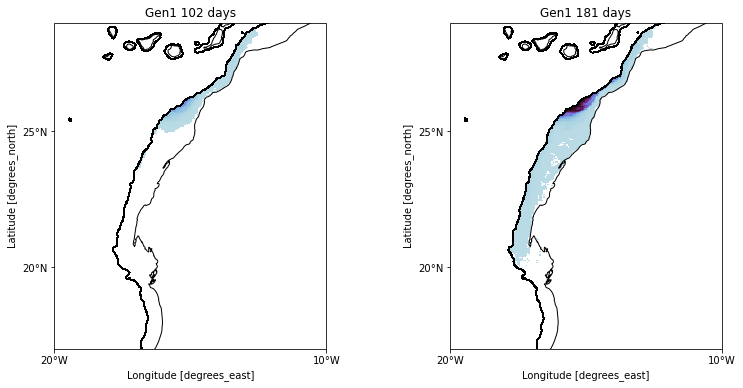

In [12]:
titles = ['Gen1 102 days', 'Gen1 181 days']
plot_hm(on_shelf100,on_shelf,'nav_lon','nav_lat', titles,(-20,-10,17,29))

In [13]:
#load 2nd gen particles
out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/second_gen//"

out_files = sorted(Path(out_path).glob("*.nc"))
output_dt_in_h = 24

lat_bins = dm_lat
lon_bins = dm_lon
def calculate_heatmap(output_dataset, lat_bins=None, lon_bins=None):
    heat_map = xhist(
        output_dataset.lat,
        output_dataset.lon,
        bins=[lat_bins, lon_bins],
        dim=["traj"],
    )
    
    heat_map = heat_map.where(heat_map > 0)
        
    return heat_map

def read_output(file):
    ds = xr.open_dataset(file)
    return ds

def load_ds(year):
    out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/second_gen/" +str(year)
    out_files = sorted(Path(out_path).glob("*.nc"))
    print(f'loaded {len(out_files)} files in year {year}')
    ds = xr.concat(map(read_output, out_files), dim="traj")
    return ds, ds.traj[-1].values
    
ds_list = year_list.copy()

for i, year in enumerate(year_list):
    ds_list[i],num = load_ds(year)

out_ds = xr.concat(ds_list,dim = 'traj')
print(out_ds.nbytes / 1e9, "GiB")

loaded 16 files in year 2007
loaded 16 files in year 2008
loaded 16 files in year 2009
loaded 16 files in year 2010
loaded 16 files in year 2011
loaded 16 files in year 2012
loaded 16 files in year 2013
loaded 16 files in year 2014
loaded 16 files in year 2015
loaded 16 files in year 2016
14.5594176 GiB


In [14]:
#locate particles on day 1 in same bins as previous generation heatmap where >1
#dataset of previous gen heatmap
test = xr.Dataset(data_vars = {'values': (['lat','lon'],on_shelf.values)}, 
                    coords = {'lon': on_shelf.coords['nav_lon'][0,:].values,
                             'lat' :on_shelf.coords['nav_lat'][:,400].values})

#see if nearest coordinate iste a bin that is positive or nan ; if positive , traj can be used
test_arr = test.sel({'lon':out_ds.isel(obs = 0).lon,'lat' : out_ds.isel(obs = 0).lat}, method = 'nearest')

#get trajectories of next generation
sec_gen_ind = np.where(~np.isnan(test_arr['values'].values))[0]
gen2_traj = out_ds.isel(traj = sec_gen_ind)

#create heatmaps 
gen2_hm = calculate_heatmap(gen2_traj, lat_bins, lon_bins).sum('obs')
gen2_hm = gen2_hm.where(gen2_hm > 0) #set all 0 to NaN for plots
gen2_shelf = gen2_hm.where((dm[1:,1:].values < 500)&(gen2_hm>0))


In [15]:
#again for 102 days heatmap from gen1
test = xr.Dataset(data_vars = {'values': (['lat','lon'],on_shelf100.values)}, #shelf100 hm
                    coords = {'lon': on_shelf100.coords['nav_lon'][0,:].values,
                             'lat' :on_shelf100.coords['nav_lat'][:,400].values})

# use .sel to see if nearest coordinate iste a bin that is positive or nan ; if positive , traj can be used
test_arr = test.sel({'lon':out_ds.isel(obs = 0).lon,'lat' : out_ds.isel(obs = 0).lat}, method = 'nearest')


#get trajectories of next generation
sec_gen_ind = np.where(~np.isnan(test_arr['values'].values))[0]
gen2_traj = out_ds.isel(traj = sec_gen_ind)

#create heamtaps 
gen2_hm100 = calculate_heatmap(gen2_traj, lat_bins, lon_bins).isel(obs = slice(0,101)).sum('obs')
gen2_hm100 = gen2_hm100.where(gen2_hm100 >0)
gen2_shelf100 = gen2_hm100.where((dm[1:,1:].values < 500)&(gen2_hm100>0))

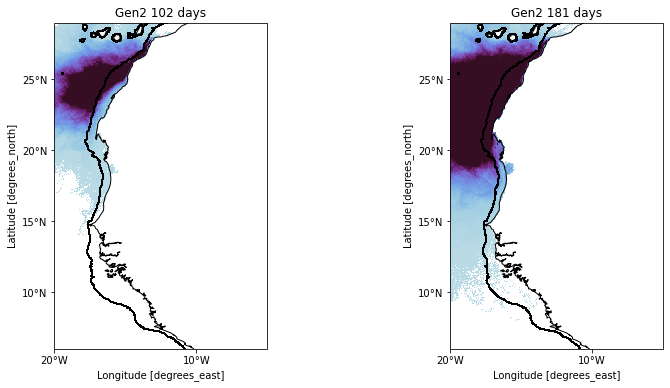

In [17]:
titles = ['Gen2 102 days', 'Gen2 181 days']
plot_hm(gen2_hm100,gen2_hm,titles = titles,extent =  (-20,-5,6,29))

In [19]:
#full particleset = out_ds
def calc_new_generation(prev_hm, short_life = False):
    prev_dataset = xr.Dataset(data_vars = {'bin_count': (['lat','lon'],prev_hm.values)}, 
                    coords = {'lon': prev_hm.coords['lon_bin'].values,#[0,:].values,
                             'lat' :prev_hm.coords['lat_bin'].values})#[:,400].values})
    prev_dataset = prev_dataset.sel({'lon':out_ds.isel(obs = 0).lon,'lat' : out_ds.isel(obs = 0).lat}, method = 'nearest')
    
    new_gen_ind = np.where(~np.isnan(prev_dataset['bin_count'].values))[0]
    new_gen_traj = out_ds.isel(traj = new_gen_ind)

    life_index = -1
    if short_life:#with or without chloroplasts
        life_index = 101
    
    new_gen_hm = calculate_heatmap(new_gen_traj, lat_bins, lon_bins).isel(obs = slice(0,life_index)).sum('obs')
    new_gen_shelf =  new_gen_hm.where((dm[1:,1:].values < 500)&(new_gen_hm>0))
    return new_gen_hm.where(new_gen_hm>0), new_gen_shelf

In [18]:
%%time
gen3_hm, gen3_shelf = calc_new_generation(gen2_shelf)
gen3_hm100, gen3_shelf100 = calc_new_generation(gen2_shelf100,short_life = True)# 102 days generation

CPU times: user 40.5 s, sys: 47.7 s, total: 1min 28s
Wall time: 1min 28s


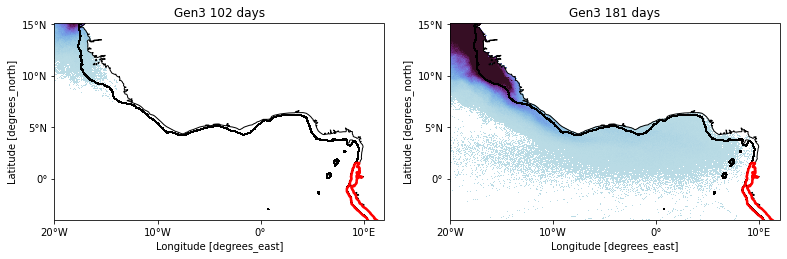

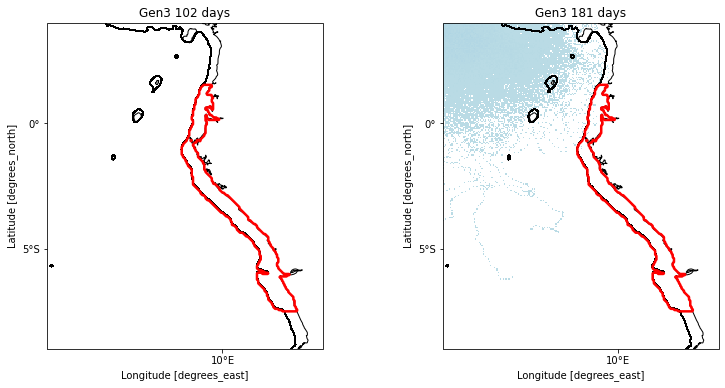

In [19]:
titles = ['Gen3 102 days', 'Gen3 181 days']
plot_hm(gen3_hm100,gen3_hm,titles = titles,extent =  (-20,12,-4,15))
plot_hm(gen3_hm100,gen3_hm,titles = titles,extent =  (3,14,-9,4))

In [20]:
%%time
gen4_hm, gen4_shelf = calc_new_generation(gen3_shelf)
gen4_hm100, gen4_shelf100 = calc_new_generation(gen3_shelf100,short_life = True)# 102 days generation

CPU times: user 1min 8s, sys: 1min 27s, total: 2min 35s
Wall time: 2min 36s


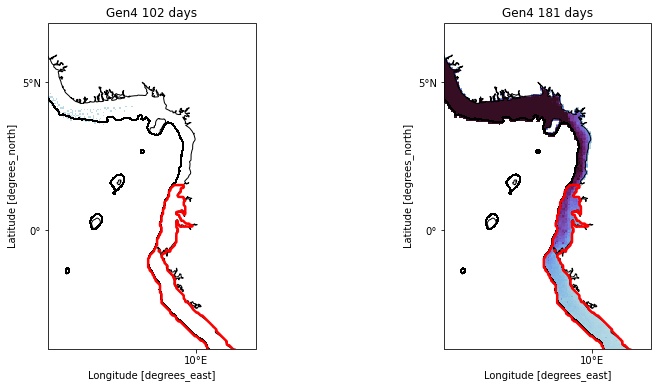

In [21]:
titles = ['Gen4 102 days', 'Gen4 181 days']
plot_hm(gen4_shelf100,gen4_shelf,titles = titles,extent = (5,12,-4,7))

In [23]:
%%time
gen5_hm, gen5_shelf = calc_new_generation(gen4_shelf)
gen5_hm100, gen5_shelf100 = calc_new_generation(gen4_shelf100,short_life = True)# 102 days generation

CPU times: user 1min 27s, sys: 43.2 s, total: 2min 10s
Wall time: 2min 11s


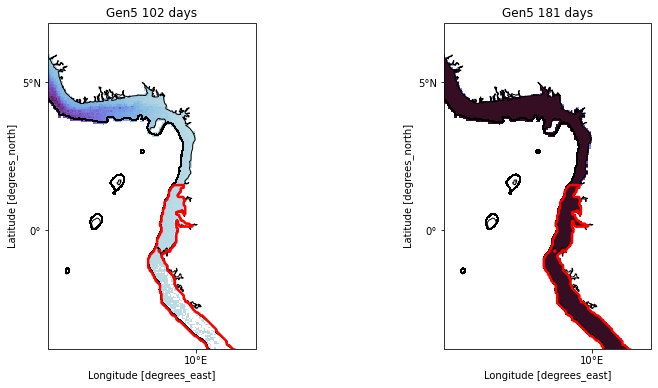

In [24]:
titles = ['Gen5 102 days', 'Gen5 181 days']
plot_hm(gen5_shelf100,gen5_shelf,titles = titles,extent = (5,12,-4,7))

In [25]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

land = cpf.NaturalEarthFeature('physical', 'land', \
    scale='50m', edgecolor='k', facecolor = cpf.COLORS['land'])

/tmp/ipykernel_3810237/3090700854.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


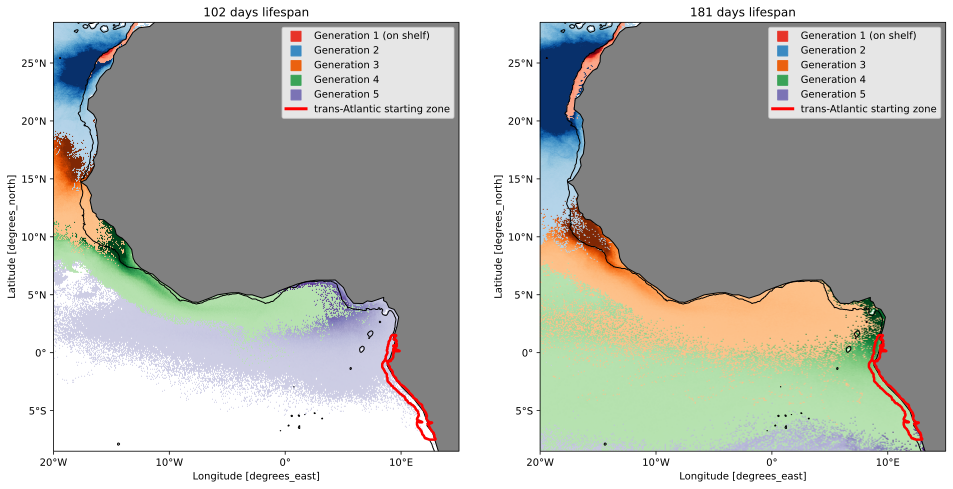

In [160]:
# big plot
titles = ['102 days lifespan', '181 days lifespan']
x_lines = np.arange(-50,30,10).tolist()#extends of plots
y_lines = np.arange(-10,35,5).tolist()#[18,20,22,24,26,28,30]

cmap1 = cmo.tools.crop_by_percent(plt.get_cmap('Purples'), 30, which='min', N=None)
cmap2 = cmo.tools.crop_by_percent(plt.get_cmap('Greens'), 30, which='min', N=None)
cmap3 = cmo.tools.crop_by_percent(plt.get_cmap('Oranges'), 30, which='min', N=None)
cmap4 = cmo.tools.crop_by_percent(plt.get_cmap('Blues'), 30, which='min', N=None)
cmap5 = cmo.tools.crop_by_percent(plt.get_cmap('Reds'), 30, which='min', N=None)

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(16, 12))


#LEFT
gen5_hm100.plot.pcolormesh(ax = ax[0],cmap = cmap1,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                        vmin=0, vmax=1e3,base=10), extend = 'max',rasterized = True)
gen4_hm100.plot.pcolormesh(ax = ax[0],cmap = cmap2,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)
gen3_hm100.plot.pcolormesh(ax = ax[0],cmap = cmap3,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)
gen2_hm100.plot.pcolormesh(ax = ax[0],cmap = cmap4,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)

on_shelf100.plot.pcolormesh(x = 'nav_lon',y = 'nav_lat',ax = ax[0],cmap = cmap5,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e2, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)
#RIGHT
gen5_hm.plot.pcolormesh(ax = ax[1],cmap = cmap1,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                        vmin=0, vmax=1e3,base=10), extend = 'max',rasterized = True)
gen4_hm.plot.pcolormesh(ax = ax[1],cmap = cmap2,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)
gen3_hm.plot.pcolormesh(ax = ax[1],cmap = cmap3,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)
gen2_hm.plot.pcolormesh(ax = ax[1],cmap = cmap4,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e3, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)

on_shelf.plot.pcolormesh(x = 'nav_lon',y = 'nav_lat',ax = ax[1],cmap = cmap5,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=1e2, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)


for i, axs in enumerate(ax.flat):
    #axs.coastlines()
    #for legend
    axs.scatter(0,40, s = 100, color = cmap5(0.5),marker = 's', label = 'Generation 1 (on shelf)',rasterized = True)
    axs.scatter(0,40, s = 100, color = cmap4(0.5),marker = 's', label = 'Generation 2',rasterized = True)
    axs.scatter(0,40, s = 100, color = cmap3(0.5),marker = 's', label = 'Generation 3',rasterized = True)
    axs.scatter(0,40, s = 100, color = cmap2(0.5),marker = 's', label = 'Generation 4',rasterized = True)
    axs.scatter(0,40, s = 100, color = cmap1(0.5),marker = 's', label = 'Generation 5',rasterized = True)
    axs.plot((0,40),(50,50), lw = 3, color = 'red', label = 'trans-Atlantic starting zone')
    #axs.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2)
    axs.add_feature(land,facecolor='gray',zorder = 2)
    
    axs.legend(loc = 'upper right')
    axs.set_xticks(x_lines[1:-1], crs=proj)
    axs.set_yticks(y_lines[1:-1], crs=proj)
    axs.xaxis.set_major_formatter(LongitudeFormatter())
    axs.yaxis.set_major_formatter(LatitudeFormatter()) 

    axs.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 1,antialiased = False, levels = [500])
    gabon_shelf.plot.contour(ax = axs,x = 'nav_lon', y = 'nav_lat', colors = 'r', levels = [0.5], linewidths = 2.5, zorder = 2)
    axs.set_extent((-20,15,-8.5,27.5))
    axs.set_title(titles[i])
#plt.savefig('pics/multigen_full_disp.png', dpi = 300, bbox_inches = 'tight')   

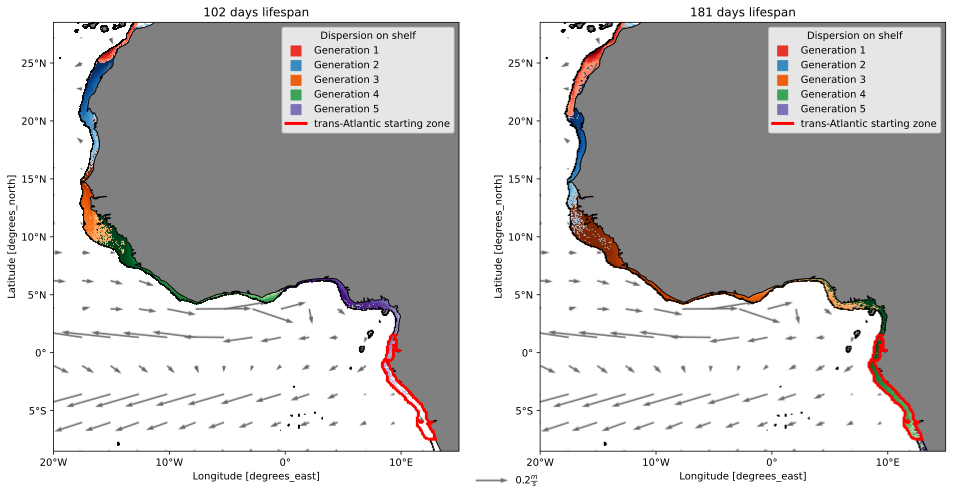

In [196]:
titles = ['102 days lifespan', '181 days lifespan']
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(16, 12))

#old threshold = 1e3 (basically linscale)
thresh = 10


#LEFT
gen5_shelf100.plot.pcolormesh(ax = ax[0],cmap = cmap1,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=thresh, linscale=1,
                                                        vmin=0, vmax=1e3,base=10), extend = 'max',rasterized = True)
gen4_shelf100.plot.pcolormesh(ax = ax[0],cmap = cmap2,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=thresh, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)
gen3_shelf100.plot.pcolormesh(ax = ax[0],cmap = cmap3,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=thresh, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)
gen2_shelf100.plot.pcolormesh(ax = ax[0],cmap = cmap4,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=thresh, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)

on_shelf100.plot.pcolormesh(x = 'nav_lon',y = 'nav_lat',ax = ax[0],cmap = cmap5,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=thresh, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)
#RIGHT
gen5_shelf.plot.pcolormesh(ax = ax[1],cmap = cmap1,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=thresh, linscale=1,
                                                        vmin=0, vmax=1e3,base=10), extend = 'max',rasterized = True)
gen4_shelf.plot.pcolormesh(ax = ax[1],cmap = cmap2,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=thresh, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)
gen3_shelf.plot.pcolormesh(ax = ax[1],cmap = cmap3,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=thresh, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)
gen2_shelf.plot.pcolormesh(ax = ax[1],cmap = cmap4,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=thresh, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)

on_shelf.plot.pcolormesh(x = 'nav_lon',y = 'nav_lat',ax = ax[1],cmap = cmap5,add_colorbar=False,
                                                               norm=colors.SymLogNorm(linthresh=thresh, linscale=1,
                                                       vmin=0, vmax=1e3, base=10), extend = 'max',rasterized = True)


for i, axs in enumerate(ax.flat):
    #axs.coastlines()
    skip = 49
    qv = axs.quiver(ulon[::skip], ulat[::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = 2.5,
            transform = proj, rasterized = True)

    #for legend
    axs.scatter(0,40, s = 100, color = cmap5(0.5),marker = 's', label = 'Generation 1',rasterized = True)
    axs.scatter(0,40, s = 100, color = cmap4(0.5),marker = 's', label = 'Generation 2',rasterized = True)
    axs.scatter(0,40, s = 100, color = cmap3(0.5),marker = 's', label = 'Generation 3',rasterized = True)
    axs.scatter(0,40, s = 100, color = cmap2(0.5),marker = 's', label = 'Generation 4',rasterized = True)
    axs.scatter(0,40, s = 100, color = cmap1(0.5),marker = 's', label = 'Generation 5',rasterized = True)
    axs.plot((0,40),(50,50), lw = 3, color = 'red', label = 'trans-Atlantic starting zone')
    #axs.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2)
    axs.add_feature(land,facecolor='gray',zorder = 2)
    
    axs.legend(loc = 'upper right', title = 'Dispersion on shelf')
    axs.set_xticks(x_lines[1:-1], crs=proj)
    axs.set_yticks(y_lines[1:-1], crs=proj)
    axs.xaxis.set_major_formatter(LongitudeFormatter())
    axs.yaxis.set_major_formatter(LatitudeFormatter()) 

    cs = axs.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = .3,antialiased = False, levels = [500])
    cs.collections[0].set_rasterized(True)
    gs = gabon_shelf.plot.contour(ax = axs,x = 'nav_lon', y = 'nav_lat', colors = 'r', levels = [0.5],antialiased = False, linewidths = 1.5, zorder = 2)
    gs.collections[0].set_rasterized(True)
    
    axs.set_extent((-20,15,-8.5,27.5))
    axs.set_title(titles[i])

ax[1].quiverkey(qv, .52, .22, .2, r'$0.2 \frac{m}{s}$', labelpos='E', 
                   coordinates='figure',zorder = 3);
#plt.savefig('pics/multigen_only_shelf.png', dpi = 300, bbox_inches = 'tight')
plt.savefig('pics/multigen_only_shelf.svg', format = 'svg', dpi = 700) 
plt.savefig('pics/multigen_only_shelf_lres.svg', format = 'svg') 

### Gen3 181 days, Gen4 and Gen5 102 days, zooms

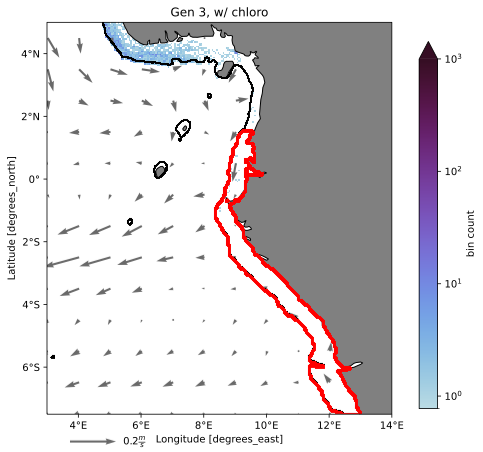

In [32]:
cb_pad = 0.07
cb_fraction = 0.047
cb_kwargs = { 'label':'bin count', 'pad' : cb_pad, 'fraction':cb_fraction, 'ticks' : [1,10,100,1000]}

skip = 20
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(7, 12))
    
gen3_shelf.plot.pcolormesh(ax = ax,cmap = cmap,cbar_kwargs = cb_kwargs,
                                                               norm=colors.SymLogNorm(linthresh=10, linscale=1,
                                                      vmin=0, vmax=1e3,
                                                                     base=10), extend = 'max',rasterized = True)

ax.add_feature(land,facecolor='gray',zorder = 2)
ax.set_xticks(np.arange(-50,30,2).tolist()[1:-1], crs=proj)
ax.set_yticks(np.arange(-10,35,2)[1:-1], crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter()) 

cs = ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 1,antialiased = False, levels = [500])
gs = gabon_shelf.plot.contour(ax = ax,x = 'nav_lon', y = 'nav_lat', colors = 'r', levels = [0.5], antialiased = False,linewidths = 2.5, zorder = 2)
cs.collections[0].set_rasterized(True)
gs.collections[0].set_rasterized(True)

ax.set_title('Gen 3, w/ chloro')
qv = ax.quiver(ulon[::skip], ulat[::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = 1.5,width = .006, 
            transform = proj, rasterized = True)

ax.set_extent((3,14,-7.5,5))
qk = ax.quiverkey(qv, .2, -0.07, .2, r'$0.2 \frac{m}{s}$', labelpos='E',
                   coordinates='axes', zorder = 4)

plt.savefig('pics/gen3shelf_chloro.svg', format = 'svg', dpi = 700) 
plt.savefig('pics/gen3shelf_chloro_lres.svg', format = 'svg')


In [28]:
from IPython.display import SVG, display

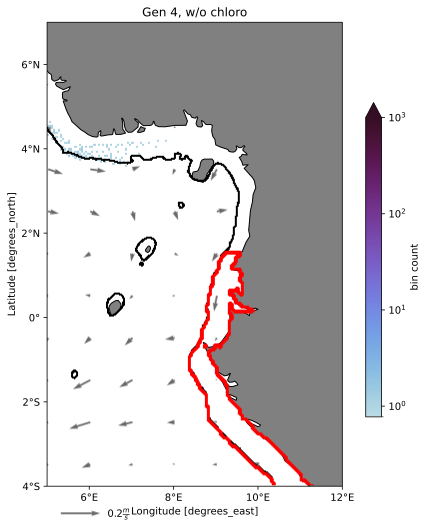

In [33]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(6, 10))
    
gen4_shelf100.plot.pcolormesh(ax = ax,cmap = cmap,cbar_kwargs = cb_kwargs,
                                                               norm=colors.SymLogNorm(linthresh=10, linscale=1,
                                                      vmin=0, vmax=1e3,
                                                                     base=10), extend = 'max',rasterized = True)

ax.add_feature(land,facecolor='gray',zorder = 2)
ax.set_xticks(np.arange(-50,30,2).tolist()[1:-1], crs=proj)
ax.set_yticks(np.arange(-10,35,2)[1:-1], crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter()) 

cs = ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 1,antialiased = False, levels = [500])
gs = gabon_shelf.plot.contour(ax = ax,x = 'nav_lon', y = 'nav_lat', colors = 'r', levels = [0.5], antialiased = False,linewidths = 2.5, zorder = 2)
cs.collections[0].set_rasterized(True)
gs.collections[0].set_rasterized(True)

ax.set_title('Gen 4, w/o chloro')
qv = ax.quiver(ulon[::skip], ulat[::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = 1.5,width = .006, 
            transform = proj, rasterized = True)

ax.set_extent((5,12,-4,7))
qk = ax.quiverkey(qv, .18, -0.06, .2, r'$0.2 \frac{m}{s}$', labelpos='E',
                   coordinates='axes', zorder = 4)

plt.savefig('pics/gen4shelf_nochloro.svg', format = 'svg', dpi = 700) 
plt.savefig('pics/gen4shelf_nochloro_lres.svg', format = 'svg')


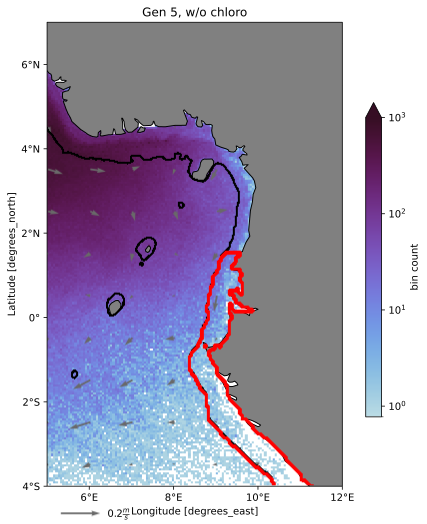

In [37]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(6, 10))
    
gen5_hm100.plot.pcolormesh(ax = ax,cmap = cmap,cbar_kwargs = cb_kwargs,
                                                               norm=colors.SymLogNorm(linthresh=10, linscale=1,
                                                      vmin=0, vmax=1e3,
                                                                     base=10), extend = 'max',rasterized = True)

ax.add_feature(land,facecolor='gray',zorder = 2)
ax.set_xticks(np.arange(-50,30,2).tolist()[1:-1], crs=proj)
ax.set_yticks(np.arange(-10,35,2)[1:-1], crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter()) 

cs = ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 1,antialiased = False, levels = [500])
gs = gabon_shelf.plot.contour(ax = ax,x = 'nav_lon', y = 'nav_lat', colors = 'r', levels = [0.5], antialiased = False,linewidths = 2.5, zorder = 2)
cs.collections[0].set_rasterized(True)
gs.collections[0].set_rasterized(True)

ax.set_title('Gen 5, w/o chloro')
qv = ax.quiver(ulon[::skip], ulat[::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = 1.5,width = .006, 
            transform = proj, rasterized = True)

ax.set_extent((5,12,-4,7))
qk = ax.quiverkey(qv, .18, -0.06, .2, r'$0.2 \frac{m}{s}$', labelpos='E',
                   coordinates='axes', zorder = 4)

plt.savefig('pics/gen5ocean_nochloro.svg', format = 'svg', dpi = 700) 
#plt.savefig('pics/gen5ocean_nochloro_lres.svg', format = 'svg')
